In [0]:
# Instalando o dataset de flores
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

In [0]:
!mkdir flower_data/test

# Instalando o conjunto de teste de flores
!wget -O flower_data_orginal_test.zip "https://www.dropbox.com/s/da6ye9genbsdzbq/flower_data_original_test.zip?dl=1"

!unzip -qq flower_data_orginal_test.zip -d /content/flower_data/test/

--2019-02-02 22:30:59--  https://www.dropbox.com/s/da6ye9genbsdzbq/flower_data_original_test.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/da6ye9genbsdzbq/flower_data_original_test.zip [following]
--2019-02-02 22:30:59--  https://www.dropbox.com/s/dl/da6ye9genbsdzbq/flower_data_original_test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc714cf27c1ffeb336ea0754ba23.dl.dropboxusercontent.com/cd/0/get/AamaCepnNT1kQGbd2qF9LTi1rF_uGLPabmP5P0_0HyJVwW8ue3XoJ4YfqArXChAWAM3wUFFVPXMblcBXxP3F9b1oYOqdoC5aovK5IrrMjY7agAZJ1ODmh7xwtiFSWtiXaxA/file?dl=1# [following]
--2019-02-02 22:30:59--  https://uc714cf27c1ffeb336ea0754ba23.dl.dropboxusercontent.com/cd/0/get/AamaCepnNT1kQGbd2qF9LTi1rF_uGLPabmP5P0_0HyJVwW8ue3XoJ4YfqArXC

In [0]:
# Importando pacotes necessários
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision
import time
import json
import itertools
import torch.nn.functional as F
import copy

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from collections import OrderedDict
from PIL import Image



In [0]:
data_dir = 'flower_data'
rescale_size = 224
crop_size = 224


# Definindo as transformações para o conjunto de treino e validação
# Definindo uma transformação para pré-processar as imagens de treinamento


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(rescale_size),                          # redimensionamento de uma pequena parte da borda para 256
        transforms.RandomCrop(crop_size),                      # obtendo 224x224 de corte de posição aleatória
        transforms.RandomHorizontalFlip(),               # Flip horizontal com probabilidade de 0.5
        transforms.ToTensor(),                           # convertendo a imagem do PIL para tensor
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])      # normalização da imagem para o modelo pré-treinado
    ]),
    'valid': transforms.Compose([
        transforms.Resize(rescale_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(rescale_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Carregando o dataset com ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}

# Definindo os dataloaders utilizando o dataset de imagens e as transformações
dataloaders = {x: 
            torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid', 'test']}

# Printando alguns dados estatísticos
print('Num training images: ', len(image_datasets['train']))
print('Num valid images: ', len(image_datasets['valid']))
print('Num test images: ', len(image_datasets['test']))


print('Num training image batches: ', len(dataloaders['train']))
print('Num valid image batches: ', len(dataloaders['valid']))
print('Num test image batches: ', len(dataloaders['valid']))

Num training images:  6552
Num valid images:  818
Num test images:  819
Num training image batches:  205
Num valid image batches:  26
Num test image batches:  26


In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
class_cat = image_datasets['train'].classes

In [0]:
# Carregando uma rede pré-treinada
model = models.densenet201(pretrained=True)



/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
# Verificando se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if  torch.cuda.is_available():
    print('Training on GPU ...')
else:
    print('Training on CPU ...')

# Congelando os parâmetros para não interferir no backpropagation
for param in model.parameters():
    param.requires_grad = False

Training on GPU ...


In [0]:
# Definindo uma rede feed-forward não treinada nova como classificador, por meio de ativações ReLU e dropout
num_classes = 102

num_ftrs = model.classifier.in_features
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))    
model.classifier = classifier

model.to(device)

criterion = nn.NLLLoss()

# Treinar apenas os parâmetros do classificador, os parâmetros de características são congelados
lr = 0.001 
optimizer = optim.Adam(model.classifier.parameters(), lr)

In [0]:
def adjust_learning_rate(optimizer, trk_epoch, lr, decay_lr_every):
    """Define a taxa de aprendizagem para o LR inicial com decaimento de 10 a cada 30 épocas"""
    new_lr = lr * (0.1 ** (trk_epoch // decay_lr_every))
    for param_group in optimizer.param_groups:
         param_group['lr'] = new_lr
    return new_lr

In [0]:
# Escrevendo uma função que carregue um checkpoint e reconstrua o modelo
# Carregando o checkpoint depois de executar o conjunto de dados e o código do arco do modelo
def load_checkpoint(model, filepath):
    checkpoint = torch.load(filepath)
    epoch = checkpoint['epoch']
    lr = checkpoint['lr']
    decay_lr_every = checkpoint['decay_lr_every']
    epoch_dict = checkpoint['epoch_dict']
    train_losses = checkpoint['train_losses_list']
    val_losses = checkpoint['val_losses_list']
    max_accuracy = checkpoint['max_accuracy']
    valid_loss_min = checkpoint['valid_loss_min']
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, epoch, train_losses, val_losses, max_accuracy, lr, decay_lr_every, epoch_dict, valid_loss_min

In [0]:
def train_function(optimizer, model, lr, decay_lr_every=20, starting_epoch=0, n_epochs=100, train_losses=[], 
                   val_losses=[], max_accuracy = 0.0, valid_loss_min=np.Inf, epoch_dict={}):
    
    print_every = 30
    trk_epoch = 0
    current_epoch = starting_epoch
    
    # se epoch_dict estiver vazio, faça a primeira entrada a partir da época 1
    if len(epoch_dict) == 0:
        epoch_dict['1'] = lr
        
    
    # Definindo taxa de aprendizado se carregar o modelo a partir do arquivo de checkpoint, ou seja, epoch! = 1
    if starting_epoch != 0:
        for param_group in optimizer.param_groups:
             param_group['lr'] = lr

    for epoch in range(starting_epoch, n_epochs):
        
#         # Ajustando e atualizando lr
#         lr = adjust_learning_rate(optimizer, trk_epoch, lr, decay_lr_every)
#         trk_epoch += 1
        
#         # quando a taxa de aprendizado muda de entrada em epoch_dict
#         if trk_epoch % decay_lr_every + 1 == 0:
#             epoch_dict[str(epoch)] = lr

        # Monitorando a perda de treinamento
        train_loss = 0.0
        val_loss = 0.0
        accuracy = 0
        steps = 0
        tm_sum = 0
        tmp_loss = 0.0
        img_size_sum = 0.0

        model.train() # modelo de preparação de treinamento

        for images, labels in dataloaders['train']:

            tic = int(round(time.time() * 1000))  # iniciando timer        
            steps += 1

            # Movendo imagens e rótulos para o dispositivo padrão
            images, labels = images.to(device), labels.to(device)

            # Limpando os gradientes de todas as variáveis otimizadas
            optimizer.zero_grad()

            # forward pass
            log_ps = model(images)

            # calculando a perda
            loss = criterion(log_ps, labels)

            # backward pass: gradiente que computa a perda em relação aos pesos/parâmetros do modelo
            loss.backward()

            # executar uma única etapa de otimização (weight/parâmetro atualizado)
            optimizer.step()

            # Dando um resultado mais preciso quando o último lote tiver reduzido o tamanho
            train_loss += loss.item()*images.size(0)
            tmp_loss += loss.item()*images.size(0)
            img_size_sum += images.size(0)

            toc = int(round(time.time() * 1000))
            batch_training_time_secs = ((toc - tic) / 1000)
            tm_sum += batch_training_time_secs

            if steps % print_every == 0:    # print every 'print_every' batches
                    avg_loss = (tmp_loss/img_size_sum)

                    print('Epoch: {}\t Batch: {}\t Avg. Batch Loss: {}\t\t Time (secs): {}'.format(epoch + 1, steps, round(avg_loss,15), round(tm_sum, 2)))
                    tm_sum = 0
                    tmp_loss = 0.0
                    img_size_sum = 0

            if  not torch.cuda.is_available():
                if steps == 100:
                    break

        else:
            # senão, medir no final da execução do loop       
            # Rastrear a perda e a precisão no conjunto de validação para determinar os melhores hiperparâmetros

            # Desligar gradientes para validação, para economizar memória e cálculos

            model.eval()

            for images, labels in dataloaders['valid']:

                # Movendo imagens e rótulos para o dispositivo padrão
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)

                temp_loss = criterion(log_ps, labels)

                val_loss += temp_loss.item()*images.size(0)

                ps = torch.exp(log_ps)

                top_p, top_class = ps.topk(1, dim=1)     # Largest element returned
                equals = top_class == labels.view(*top_class.shape)   
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*images.size(0)

            # Calculando a perda média ao longo de uma época
            train_loss = train_loss/len(dataloaders['train'].dataset)
            val_loss = val_loss/len(dataloaders['valid'].dataset)
            accuracy = accuracy/len(dataloaders['valid'].dataset)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                  "Training Loss: {:.3f}.. ".format(train_loss),
                  "Val. Loss: {:.3f}.. ".format(val_loss),
                  "Val. Accuracy: {:.3f}".format(accuracy), end=' ') # end=' ', next print will be on same line

            # Excluindo 0.0 de max accuracy
            if max_accuracy == 0.0:
                max_accuracy = accuracy
                
            # Exluindo np.Inf de min validation
            if valid_loss_min == np.Inf:
                valid_loss_min = val_loss
                
            # Definindo os parâmetros de checkpoint
            def get_checkpoint():    
                return   {'epoch': epoch,
                          'lr': lr,
                          'decay_lr_every':decay_lr_every,
                          'epoch_dict':epoch_dict,
                          'class_to_idx':model.class_to_idx,
                          'train_losses_list':train_losses,
                          'val_losses_list':val_losses,
                          'max_accuracy':max_accuracy,
                          'valid_loss_min':valid_loss_min,
                          'state_dict': model.state_dict()}
            
            
            # Salvando o modelo se a perda de validação tiver diminuído    
            if val_loss <= valid_loss_min:                
                print('Saving val model.', end=' ')
                valid_loss_min = val_loss
                
                # Salvando checkpoint 
                model.class_to_idx = image_datasets['train'].class_to_idx
                torch.save(get_checkpoint(), 'checkpoint_val.pth')

            # Salvando o modelo se a acurácia tiver aumentado
            if accuracy >= max_accuracy:
                print('Saving accuracy model.')
                max_accuracy = accuracy
                
                # Salvando o checkpoint 
                model.class_to_idx = image_datasets['train'].class_to_idx
                torch.save(get_checkpoint(), 'checkpoint_acc.pth')
            else:
                # Limpando o buffer
                print("")
                                 
            # Salvando o último checkpoint 
            model.class_to_idx = image_datasets['train'].class_to_idx
            torch.save(get_checkpoint(), 'checkpoint.pth')

In [0]:
train_function(optimizer, model, lr, decay_lr_every=20, 
               starting_epoch=0, n_epochs=100, train_losses=[], 
               
val_losses=[], max_accuracy=0.0, valid_loss_min=np.Inf, epoch_dict={})

Epoch: 1	 Batch: 30	 Avg. Batch Loss: 4.317712688446045		 Time (secs): 11.67
Epoch: 1	 Batch: 60	 Avg. Batch Loss: 3.130937457084656		 Time (secs): 11.64
Epoch: 1	 Batch: 90	 Avg. Batch Loss: 2.317489246527354		 Time (secs): 11.62
Epoch: 1	 Batch: 120	 Avg. Batch Loss: 1.69980753660202		 Time (secs): 11.67
Epoch: 1	 Batch: 150	 Avg. Batch Loss: 1.354714910189311		 Time (secs): 11.73
Epoch: 1	 Batch: 180	 Avg. Batch Loss: 1.133859952290853		 Time (secs): 11.68
Epoch: 1/100..  Training Loss: 2.154..  Val. Loss: 0.788..  Val. Accuracy: 0.884 Saving val model. Saving accuracy model.
Epoch: 2	 Batch: 30	 Avg. Batch Loss: 0.684171378612518		 Time (secs): 11.64
Epoch: 2	 Batch: 60	 Avg. Batch Loss: 0.6007187773784		 Time (secs): 11.63
Epoch: 2	 Batch: 90	 Avg. Batch Loss: 0.597321819265684		 Time (secs): 11.61
Epoch: 2	 Batch: 120	 Avg. Batch Loss: 0.519946759939194		 Time (secs): 11.68
Epoch: 2	 Batch: 150	 Avg. Batch Loss: 0.453587347765764		 Time (secs): 11.67
Epoch: 2	 Batch: 180	 Avg. Ba

In [0]:
# Carregando o modelo com a métrica escolhida
model, epoch, train_losses, val_losses, max_accuracy, lr, decay_lr_every, epoch_dict, valid_loss_min = load_checkpoint(model, 
                                                                                                        'checkpoint_acc.pth')

In [0]:
# Computando acurácia de validação para cada época

val_loss = 0.0
num_classes = 102
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

model.eval()

for images, labels in dataloaders['valid']:

    # Movendo imagens e rótulos para o dispositivo padrão
    images, labels = images.to(device), labels.to(device)
    log_ps = model(images)

    temp_loss = criterion(log_ps, labels)

    val_loss += temp_loss.item()*images.size(0)

    ps = torch.exp(log_ps)

    top_p, top_class = ps.topk(1, dim=1)     # Elemento maior retornado
    equals = top_class == labels.view(*top_class.shape)
    
    # Calculando a acurácia do teste para cada objeto da classe
    for i in range(images.size(0)):
        label = labels.data[i]
        class_correct[label-1] += equals[i].item()
        class_total[label-1] += 1
    
val_loss = val_loss/len(dataloaders['valid'].dataset)
print('Val Loss: {:.6f}\n'.format(val_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Val Accuracy of %3s: %2d%% (%2d/%2d)' % (str(i+1), 100 * class_correct[i] / class_total[i],
                                                                        class_correct[i], class_total[i]))
    else:
        print('Val Accuracy of %3s: N/A (no training example)' % (str(i+1)))

print('\nVal Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                                            np.sum(class_correct), np.sum(class_total)))

Val Loss: 0.162487

Val Accuracy of   1: 100% ( 4/ 4)
Val Accuracy of   2: 100% ( 6/ 6)
Val Accuracy of   3: 100% ( 5/ 5)
Val Accuracy of   4: 100% ( 6/ 6)
Val Accuracy of   5: 100% (10/10)
Val Accuracy of   6: 100% ( 5/ 5)
Val Accuracy of   7: 100% ( 5/ 5)
Val Accuracy of   8: 100% ( 1/ 1)
Val Accuracy of   9: 100% ( 7/ 7)
Val Accuracy of  10: 100% ( 2/ 2)
Val Accuracy of  11: 100% (16/16)
Val Accuracy of  12: 100% (11/11)
Val Accuracy of  13: 100% ( 4/ 4)
Val Accuracy of  14: 100% ( 6/ 6)
Val Accuracy of  15: 71% ( 5/ 7)
Val Accuracy of  16: 100% ( 4/ 4)
Val Accuracy of  17: 100% ( 8/ 8)
Val Accuracy of  18: 100% (12/12)
Val Accuracy of  19: 100% ( 5/ 5)
Val Accuracy of  20: 100% ( 2/ 2)
Val Accuracy of  21: 100% ( 3/ 3)
Val Accuracy of  22: 100% ( 1/ 1)
Val Accuracy of  23: 100% ( 5/ 5)
Val Accuracy of  24: 100% ( 7/ 7)
Val Accuracy of  25: 100% ( 2/ 2)
Val Accuracy of  26: 80% ( 8/10)
Val Accuracy of  27: 100% ( 2/ 2)
Val Accuracy of  28: 100% ( 3/ 3)
Val Accuracy of  29: 85% ( 6/ 

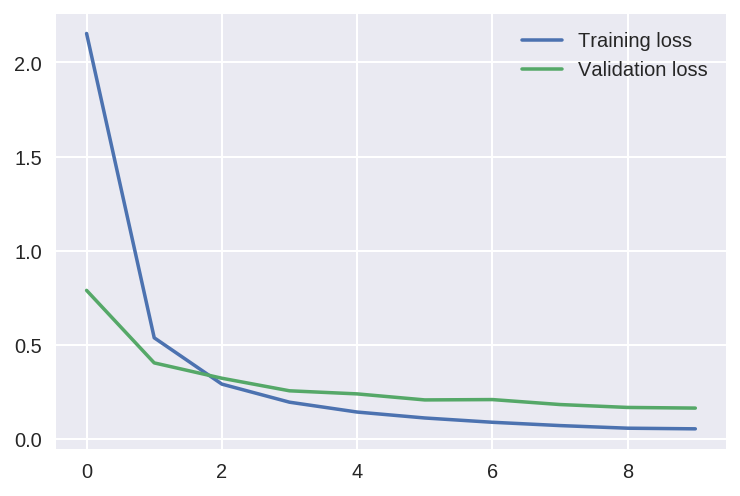

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [0]:
# Computando a acurácia do teste para cada classe

val_loss = 0.0
num_classes = 102
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

model.eval()

for images, labels in dataloaders['test']:

    # Movendo imagens e rótulos para o dispositivo padrão
    images, labels = images.to(device), labels.to(device)
    log_ps = model(images)

    temp_loss = criterion(log_ps, labels)

    val_loss += temp_loss.item()*images.size(0)

    ps = torch.exp(log_ps)

    top_p, top_class = ps.topk(1, dim=1)     # Elemento maior retornado
    equals = top_class == labels.view(*top_class.shape)
    
    # Calculando a acurácia do teste para cada objeto da classe
    for i in range(images.size(0)):
        label = labels.data[i]
        class_correct[label-1] += equals[i].item()
        class_total[label-1] += 1
    
val_loss = val_loss/len(dataloaders['test'].dataset)
print('Test Loss: {:.6f}\n'.format(val_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (str(i+1), 100 * class_correct[i] / class_total[i],
                                                                        class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %3s: N/A (no training example)' % (str(i+1)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                                            np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.191924

Test Accuracy of   1: 100% ( 3/ 3)
Test Accuracy of   2: 100% ( 8/ 8)
Test Accuracy of   3: 100% ( 4/ 4)
Test Accuracy of   4: 100% ( 6/ 6)
Test Accuracy of   5: 100% ( 9/ 9)
Test Accuracy of   6: 88% ( 8/ 9)
Test Accuracy of   7: 100% ( 6/ 6)
Test Accuracy of   8: 100% ( 3/ 3)
Test Accuracy of   9: 100% ( 4/ 4)
Test Accuracy of  10: 100% ( 3/ 3)
Test Accuracy of  11: 100% ( 9/ 9)
Test Accuracy of  12: 100% ( 6/ 6)
Test Accuracy of  13: 100% ( 7/ 7)
Test Accuracy of  14: 100% ( 5/ 5)
Test Accuracy of  15: 66% ( 2/ 3)
Test Accuracy of  16: 100% ( 2/ 2)
Test Accuracy of  17: 100% ( 4/ 4)
Test Accuracy of  18: 100% ( 7/ 7)
Test Accuracy of  19: 100% ( 2/ 2)
Test Accuracy of  20: 100% ( 5/ 5)
Test Accuracy of  21: 80% ( 4/ 5)
Test Accuracy of  22: 100% ( 3/ 3)
Test Accuracy of  23: 100% ( 6/ 6)
Test Accuracy of  24: 100% ( 9/ 9)
Test Accuracy of  25: 100% ( 2/ 2)
Test Accuracy of  26: 100% (14/14)
Test Accuracy of  27: 100% ( 2/ 2)
Test Accuracy of  28: 50% ( 3/ 6)
Tes

In [0]:
def process_image(image):
    ''' Escalando, cortando e normalizando uma imagem PIL para um modelo PyTorch, retornando um array Numpy    '''
    # Processando uma imagem PIL para uso em um modelo PyTorch
    img = Image.open(image)
    
    # rescale
    output_size = rescale_size
    w, h = img.size
    if h > w:
        new_h, new_w = output_size * h / w, output_size
    else:
        new_h, new_w = output_size, output_size * w / h
        
    new_h, new_w = int(new_h), int(new_w)
    
    # resize
    img = img.resize((new_w, new_h))
    
    # corte central
    new_height, new_width = crop_size, crop_size

    left = (new_w - new_width)//2
    right = (new_w + new_width)//2
    top = (new_h - new_height)//2   
    bottom = (new_h + new_height)//2

    img = img.crop((left, top, right, bottom))
    
    # Normalizando uma imagem para um intervalo 0,1
    np_image = np.array(img)
    np_image = np_image/255.0
    
    # alternando eixo de cor pois:
    # imagem numpy: H x W x C
    # imagem torch: C X H X W
    tch_image = np_image.transpose((2, 0, 1))
    tch_image[0,:,:] = (tch_image[0,:,:] - 0.485) / 0.229
    tch_image[1,:,:] = (tch_image[1,:,:] - 0.456) / 0.224
    tch_image[2,:,:] = (tch_image[2,:,:] - 0.406) / 0.225
    
    tch_image = torch.from_numpy(tch_image)
    
    return tch_image

In [0]:
image_path = 'flower_data/test/46/image_01090.jpg'
tch_image = process_image(image_path)

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # Os tensores do PyTorch assumem que o canal de cor é a primeira dimensão
    # mas o matplotlib assume que é de terceira dimensão
    image = image.numpy().transpose((1, 2, 0))
    
    # Desfazendo pré-processamento
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # A imagem precisa ser cortada entre 0 e 1 ou então parecerá ruído quando exibida
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

def tensor_to_img(image, ax=None, title=None):
    """Imshow para Tensor."""
    # Os tensores do PyTorch assumem que o canal de cor é a primeira dimensão
    # mas o matplotlib assume que é de terceira dimensão
    image = image.numpy().transpose((1, 2, 0))
    
    # Desfazendo pré-processamento
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # A imagem precisa ser cortada entre 0 e 1 ou então parecerá ruído quando exibida
    image = np.clip(image, 0, 1)
    
    return image

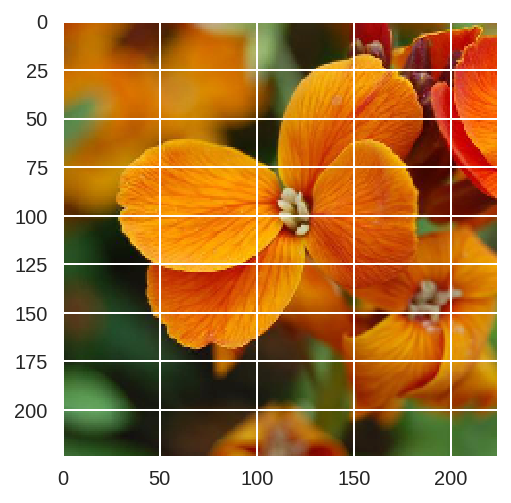

In [0]:
img = imshow(tch_image)

In [0]:
def predict(image_path, model, topk=5):
    ''' Realizando a predição da classe (ou classes) de uma imagem usando um modelo treinado de deep learning.
    '''
    
    # Implementando a predição da classe de um arquivo de imagem
    tch_image = process_image(image_path)
    
    # Adicionando um batch dim
    tch_image = tch_image.unsqueeze(0)
    tch_image = tch_image.type(torch.FloatTensor)
    
    # Movendo imagens e rótulos para o dispositivo padrão
    tch_image = tch_image.to(device)
    log_ps = model(tch_image)                
    ps = torch.exp(log_ps)

    top_p, top_idx = ps.topk(topk, dim=1)
    
    # Convertendo índices para classes
    class_to_idx = model.class_to_idx
    idx_to_class = {ii: cl for cl, ii in class_to_idx.items()}
    
    top_p = np.squeeze(top_p.data.numpy()) if not torch.cuda.is_available() else np.squeeze(top_p.cpu().data.numpy())
    top_idx = np.squeeze(top_idx.numpy()) if not torch.cuda.is_available() else np.squeeze(top_idx.cpu().numpy())
    
    top_class = [idx_to_class[idx] for idx in top_idx]    
    top_p = top_p.tolist()
    
    return top_p, top_class

In [0]:
topk=5
top_p, top_class = predict(image_path, model, topk)
print(top_p)
print(top_class)

[0.9921799302101135, 0.002775922417640686, 0.002279126551002264, 0.0002792281738948077, 0.00023539128596894443]
['46', '53', '18', '26', '101']


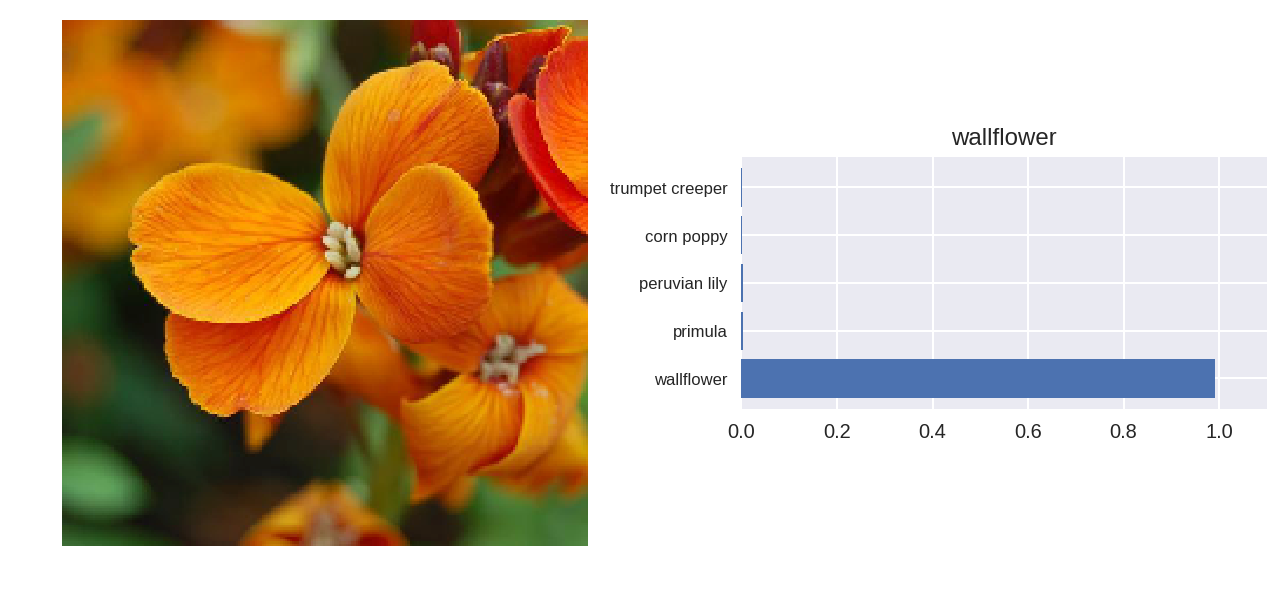

In [0]:
# Exibindo uma imagem com as 5 principais classes
tch_image = process_image(image_path)
np_image = tensor_to_img(tch_image)
top_p, top_class = predict(image_path, model, topk) 

max_index = top_p.index(max(top_p))

top_p = np.array(top_p)

fig, (ax1, ax2) = plt.subplots(figsize=(9,14), ncols=2)
ax1.imshow(np_image)
ax1.axis('off')
ax2.barh(np.arange(topk), top_p)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(topk))

top_class_name = [cat_to_name[cat] for cat in top_class]

ax2.set_yticklabels(top_class_name, size='small');
ax2.set_title(cat_to_name[top_class[max_index]])
ax2.set_xlim(0, 1.1)

plt.tight_layout()